# Data Challenge - Bike Sharing Demand Prediction

## Dataset Information
Our training dataset contains information from 12,165 hours over 731 days with 14 features (information categories)  and 1 target for each hour.
The file named *train.csv* contains the training set of the problem, while the file *test.csv* contains the test set of the problem. Each line of these two files corresponds to a bike sharing record characterized by the following variables:
Variable | Description
--- | --- | ---
season | season (1:winter, 2:spring, 3:summer, 4:fall)
yr | year (0: 2011, 1:2012)
mnth | month (1 to 12)
hr | hour (0 to 23)
holiday | weather day is holiday or not
weekday|day of the week
workingday | if day is neither weekend nor holiday is 1, otherwise is 0.
weathersit | 1: Clear, Few clouds, Partly cloudy, Partly cloudy
| 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
| 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
| 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog
temp | Normalized temperature in Celsius. The values are derived via (t-t_min)/(t_max-t_min), t_min=-8, t_max=+39 (only in hourly scale)
atemp | Normalized feeling temperature in Celsius. The values are derived via (t-t_min)/(t_max-t_min), t_min=-16, t_max=+50 (only in hourly scale)
hum | Normalized humidity. The values are divided to 100 (max)
windspeed | Normalized wind speed. The values are divided to 67 (max)
casual | count of casual users
registered | count of registered users
cnt | count of total rental bikes including both casual and registered
The training set contains the variable `cnt` which is related to the number of bicycles rented in any given 1 hour time-period. The `cnt` (and also `casual` and `registered` which obviously contain direct information about the bike sharing count) variable is missing from the test set as it is the variable to be predicted.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sn
from scipy import stats
from numpy import median
from sklearn import metrics
from sklearn import model_selection
from sklearn.metrics import mean_squared_log_error, r2_score
from sklearn.model_selection import train_test_split, GridSearchCV,RandomizedSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import ExtraTreesRegressor,VotingRegressor, RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
import xgboost as xgb
from sklearn.neighbors import KNeighborsRegressor

In [2]:
# Reading training data from the local storage
filename = 'train.csv' 
df_train = pd.read_csv(filename)
print(df_train.shape)
df_train.head(5)

(12165, 15)


,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,4,0,11,0,0,2,1,1,0.56,0.5303,0.64,0.3582,7,15,22
1,1,0,2,21,0,6,0,1,0.28,0.2727,0.65,0.2537,9,59,68
2,4,1,11,12,0,3,1,1,0.44,0.4394,0.41,0.1940,74,270,344
3,1,1,1,7,0,2,1,2,0.18,0.1970,0.93,0.1642,3,219,222
4,1,1,3,16,0,1,1,1,0.30,0.2727,0.45,0.2985,30,180,210


Rename Column Names

In [3]:
df_train.rename(columns={'weathersit':'weather',
                     'mnth':'month',
                     'hr':'hour',
                     'yr':'year',
                     'hum': 'humidity',
                     'cnt':'count'},inplace=True)
df_train.head()

,season,year,month,hour,holiday,weekday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,4,0,11,0,0,2,1,1,0.56,0.5303,0.64,0.3582,7,15,22
1,1,0,2,21,0,6,0,1,0.28,0.2727,0.65,0.2537,9,59,68
2,4,1,11,12,0,3,1,1,0.44,0.4394,0.41,0.1940,74,270,344
3,1,1,1,7,0,2,1,2,0.18,0.1970,0.93,0.1642,3,219,222
4,1,1,3,16,0,1,1,1,0.30,0.2727,0.45,0.2985,30,180,210


Some data types need to be changed from numerical to categorical in order for the model to interpret better these variables. After some tries we found that these variables optimize better our model.

In [4]:
#Convert to object type
df_train['season'] = df_train.season.astype('object')
#df_train['year'] = df_train.year.astype('object')
#df_train['month'] = df_train.month.astype('object')
#df_train['hour'] = df_train.hour.astype('object')
df_train['holiday'] = df_train.holiday.astype('object')
df_train['weekday'] = df_train.weekday.astype('object')
df_train['workingday'] = df_train.workingday.astype('object')
#df_train['weather'] = df_train.weather.astype('object')

df_train.dtypes

season         object
year            int64
month           int64
hour            int64
holiday        object
weekday        object
workingday     object
weather         int64
temp          float64
atemp         float64
humidity      float64
windspeed     float64
casual          int64
registered      int64
count           int64
dtype: object

###  Exploratory Data Analysis

Analyze the change in bike sharing pattern (`count` variable) with categorical variables:

<AxesSubplot:xlabel='workingday', ylabel='count'>

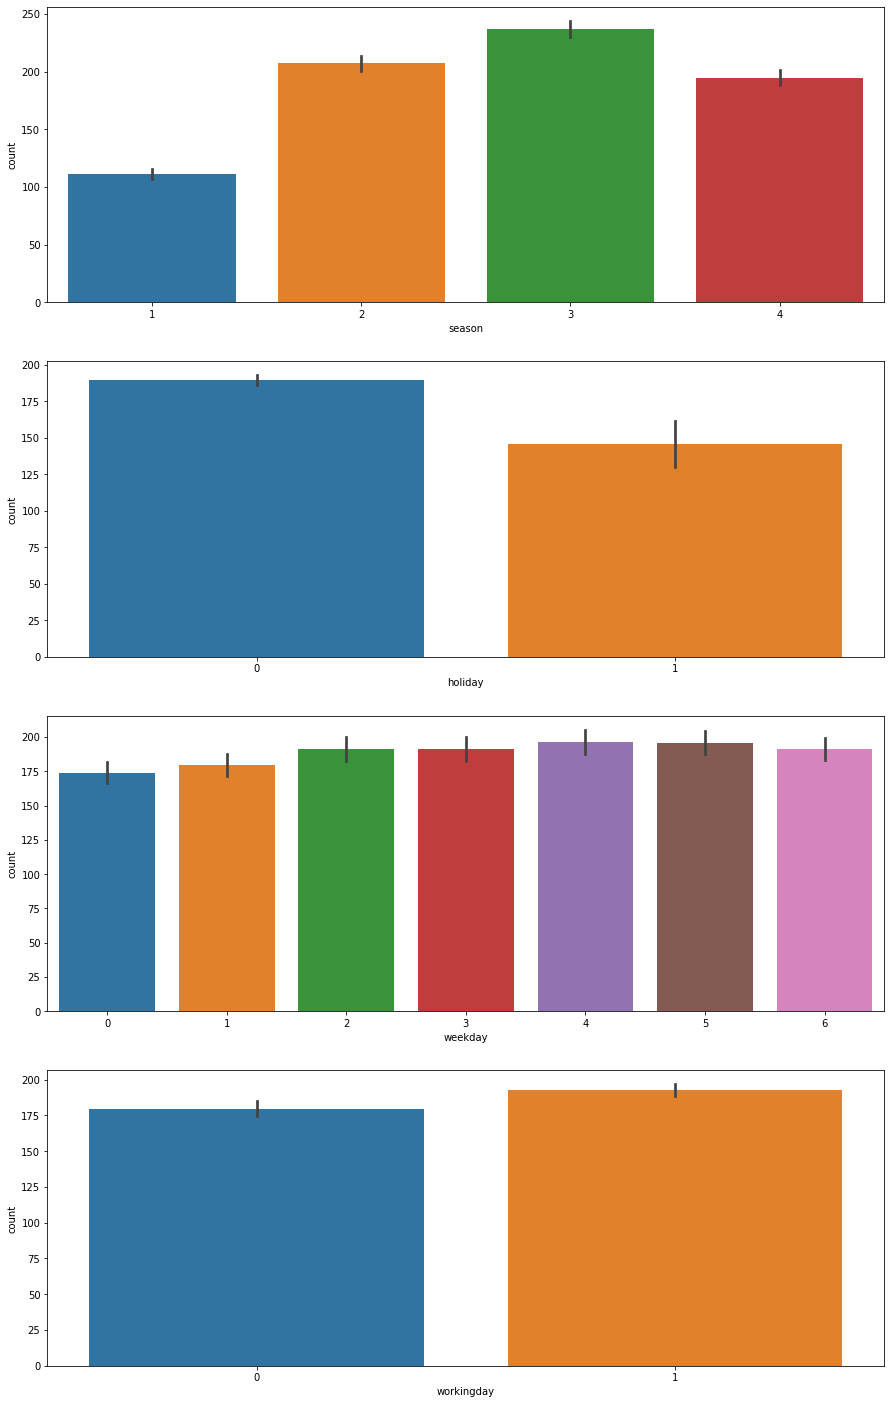

In [5]:
fig,[ax1,ax2,ax3,ax4] = plt.subplots(nrows=4, figsize=(15,25))
sn.barplot(x = df_train['season'], y = df_train['count'],ax = ax1)
sn.barplot(x = df_train['holiday'], y = df_train['count'],ax = ax2)
sn.barplot(x = df_train['weekday'], y = df_train['count'],ax = ax3)
sn.barplot(x = df_train['workingday'], y = df_train['count'],ax = ax4)

### Correlation Analysis

To see how numerical variables are connected with each other, data correlation can be checked:

<AxesSubplot:>

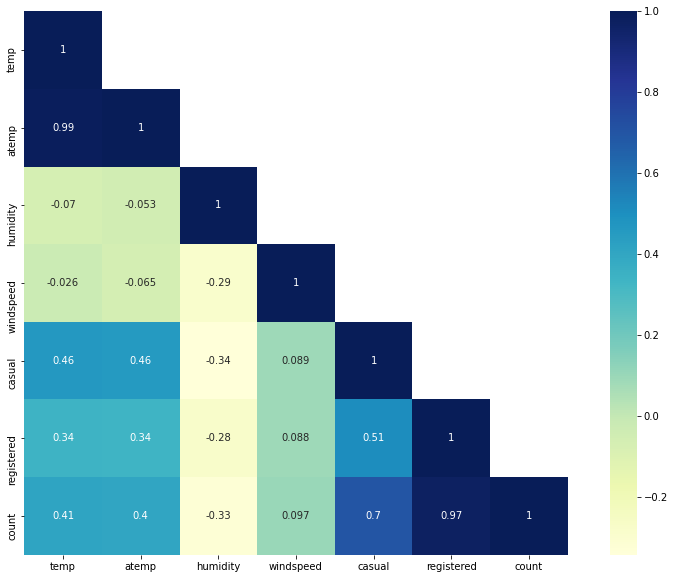

In [6]:
data_corr = df_train[['temp', 'atemp', 'humidity', 'windspeed', 'casual', 'registered', 'count']].corr()
mask = np.array(data_corr)
mask[np.tril_indices_from(mask)] = False
fig = plt.subplots(figsize=(15, 10))
sn.heatmap(data_corr, mask=mask, vmax=1, square=True, annot=True, cmap="YlGnBu")

It can be observed that:
- `temp` and `atemp` are strongly correlated. To reduce the dimensionality of the predictive model, the feature `temp` is dismissed.
- `casual` and `registered` contain direct information about the bike sharing `count` which we want to predict (data leakage). Therefore they are not considered in the feature set.
- `atemp` has positive correlation and `humidity` has negative correlation with `count`.
- `windspeed` has little correlation with `count`.
- The variables `hour` and `atemp` seem to be promising features for the bike sharing count prediction.

# Model building

In [7]:
#Drop columns casual, registered, windspeed
df_train = df_train.drop(['casual', 'registered', 'windspeed'], axis=1)
df_train.head()

,season,year,month,hour,holiday,weekday,workingday,weather,temp,atemp,humidity,count
0,4,0,11,0,0,2,1,1,0.56,0.5303,0.64,22
1,1,0,2,21,0,6,0,1,0.28,0.2727,0.65,68
2,4,1,11,12,0,3,1,1,0.44,0.4394,0.41,344
3,1,1,1,7,0,2,1,2,0.18,0.1970,0.93,222
4,1,1,3,16,0,1,1,1,0.30,0.2727,0.45,210


In [36]:
#Training data
X = df_train[['season','year','month','hour','holiday','weekday','workingday','weather','atemp','humidity']]

#One-hot encoding technique for better performance
X = pd.get_dummies(X)

#Set the target
y = df_train['count']

#Data split into test and train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [9]:
#Print shapes
print('X_train shape: ',X_train.shape)
print('y_train shape: ',y_train.shape)
print('X_test shape: ',X_test.shape)
print('y_test shape: ',y_test.shape)

X_train shape:  (9732, 21)
y_train shape:  (9732,)
X_test shape:  (2433, 21)
y_test shape:  (2433,)


We first start testing the performance of different regression algorithms.

In [10]:
#Initialize models
models=[ExtraTreesRegressor(),RandomForestRegressor(),AdaBoostRegressor(),KNeighborsRegressor(), xgb.XGBRegressor(),DecisionTreeRegressor(),GradientBoostingRegressor()]
model_names=['ExtraTreeRegressor','RandomForestRegressor','AdaBoostRegressor','KNeighborsRegressor','XGBRegressor','DecisionTreeRegressor','GradientBoostingRegressor']
rmsle=[]
d={}

#Fit and predict
for model in range (len(models)):
    clf=models[model]
    clf.fit(X_train,y_train)
    y_pred=clf.predict(X_test)
    for i, _  in enumerate(y_pred):
        if y_pred[i] < 0:
            y_pred[i] = 0
    rmsle.append(np.sqrt(mean_squared_log_error(y_pred,y_test)))
    
#Create DataFrame from Model,RMSLE
d={'Modelling Algo':model_names,'RMSLE':rmsle}   
rmsle_frame=pd.DataFrame(d)
rmsle_frame

,Modelling Algo,RMSLE
0,ExtraTreeRegressor,0.332168
1,RandomForestRegressor,0.342849
2,AdaBoostRegressor,1.077291
3,KNeighborsRegressor,0.415221
4,XGBRegressor,0.502447
5,DecisionTreeRegressor,0.473374
6,GradientBoostingRegressor,0.745488


c:\users\zisis\appdata\local\programs\python\python39\lib\site-packages\seaborn\categorical.py:3714: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
c:\users\zisis\appdata\local\programs\python\python39\lib\site-packages\seaborn\categorical.py:3720: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


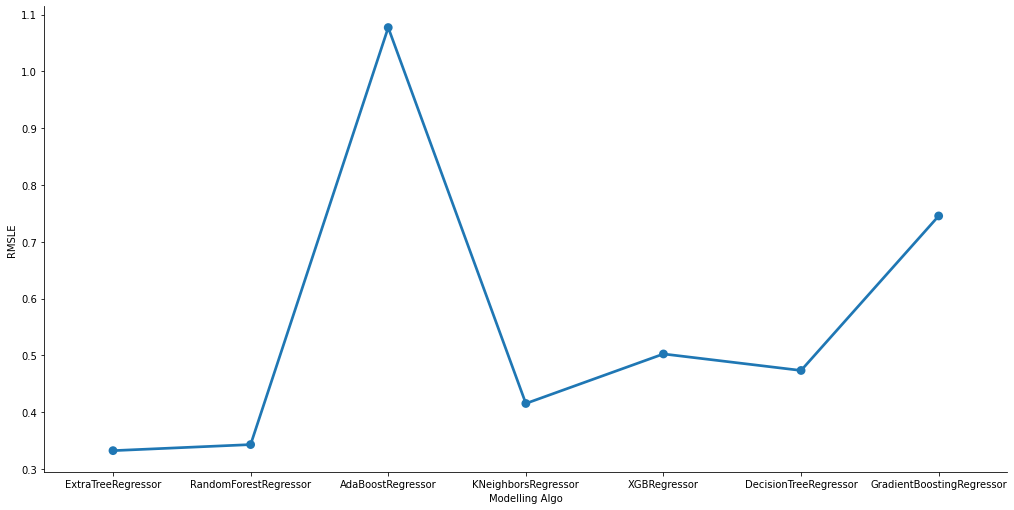

In [11]:
sn.factorplot(x='Modelling Algo',y='RMSLE',data=rmsle_frame,kind='point',size=7,aspect=2)

We see that ExtraTreesRegressor has the best RMSLE score so we start with it. We want to find the best parameters so we use GridSearchCV.

In [37]:
#Initialize ExtraTreesRegressor
clf = ExtraTreesRegressor()

#Initialize params
# param_grid = {
#     'n_estimators': [200,300,500],
#     'n_jobs':[-1],
#     'random_state':[42,52,62],
#     'min_samples_split': [2,3,4],
#     'max_depth': [100,200,300]
# }
param_grid = {
    'n_estimators': [300, 500],
    'n_jobs':[-1],
    'random_state':[42, 52],
    'min_samples_split': [3, 4],
    'max_depth': [100, 200]
}
#Initialize GridSearchCV
grid_search = GridSearchCV(estimator = clf, param_grid = param_grid, verbose = 2)

#Fit GridSearchCV
grid_search.fit(X_train,y_train)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV] END max_depth=100, min_samples_split=3, n_estimators=300, n_jobs=-1, random_state=42; total time=  10.1s
[CV] END max_depth=100, min_samples_split=3, n_estimators=300, n_jobs=-1, random_state=42; total time=   4.3s
[CV] END max_depth=100, min_samples_split=3, n_estimators=300, n_jobs=-1, random_state=42; total time=   4.3s
[CV] END max_depth=100, min_samples_split=3, n_estimators=300, n_jobs=-1, random_state=42; total time=   3.9s
[CV] END max_depth=100, min_samples_split=3, n_estimators=300, n_jobs=-1, random_state=42; total time=   4.0s
[CV] END max_depth=100, min_samples_split=3, n_estimators=300, n_jobs=-1, random_state=52; total time=   4.2s
[CV] END max_depth=100, min_samples_split=3, n_estimators=300, n_jobs=-1, random_state=52; total time=   3.7s
[CV] END max_depth=100, min_samples_split=3, n_estimators=300, n_jobs=-1, random_state=52; total time=   4.3s
[CV] END max_depth=100, min_samples_split=3, n_estimators=3

[CV] END max_depth=200, min_samples_split=4, n_estimators=500, n_jobs=-1, random_state=42; total time=   7.1s
[CV] END max_depth=200, min_samples_split=4, n_estimators=500, n_jobs=-1, random_state=52; total time=   7.2s
[CV] END max_depth=200, min_samples_split=4, n_estimators=500, n_jobs=-1, random_state=52; total time=   7.2s
[CV] END max_depth=200, min_samples_split=4, n_estimators=500, n_jobs=-1, random_state=52; total time=   7.2s
[CV] END max_depth=200, min_samples_split=4, n_estimators=500, n_jobs=-1, random_state=52; total time=   7.2s
[CV] END max_depth=200, min_samples_split=4, n_estimators=500, n_jobs=-1, random_state=52; total time=   7.4s


GridSearchCV(estimator=ExtraTreesRegressor(),
             param_grid={'max_depth': [100, 200], 'min_samples_split': [3, 4],
                         'n_estimators': [300, 500], 'n_jobs': [-1],
                         'random_state': [42, 52]},
             verbose=2)

In [38]:
#Find the best params
print(grid_search.best_params_)

#Find the best estimator
best_grid = grid_search.best_estimator_

#Fit with the best params
best_grid.fit(X_train, y_train)

#Predict
y_pred = best_grid.predict(X_test)

#If predicted value is negative then we set it zero.
for i, _  in enumerate(y_pred):
    if y_pred[i] < 0:
        y_pred[i] = 0

#Print RMSLE Score
print('RMSLE:', np.sqrt(mean_squared_log_error(y_test, y_pred)))

{'max_depth': 100, 'min_samples_split': 4, 'n_estimators': 500, 'n_jobs': -1, 'random_state': 52}
RMSLE: 0.3305973730187315


c:\users\zisis\appdata\local\programs\python\python39\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


[Text(0.5, 1.0, 'Comparison between the actual vs predicted values')]

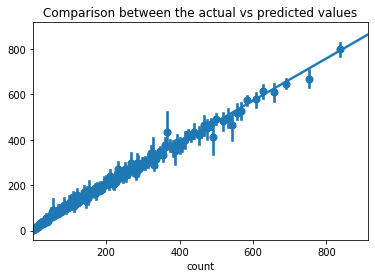

In [39]:
#Plot comparison between the actual versus the predicted value
ax = sn.regplot(y_test, y_pred, x_bins = 200)
ax.set(title = "Comparison between the actual vs predicted values")

We also tested PCA, SVD for dimensionality reduction, but we didn't see any imrovement, so we didn't include it in this notebook.

Then tested Voting Regressor which use not so good algorithms, but the combination of them gives a very good result.

In [40]:
# Use best parameters found before
rf = RandomForestRegressor()
dt = DecisionTreeRegressor()

#Voting
vr = VotingRegressor(estimators=[('rf', rf), ('dt', dt)], n_jobs=-1)
vr.fit(X_train, y_train)
#Prediction
y_pred = vr.predict(X_test)
for i, _  in enumerate(y_pred):
    if y_pred[i] < 0:
        y_pred[i] = 0
print('RMSLE: ', (np.sqrt(mean_squared_log_error(y_pred,y_test))))

RMSLE:  0.3695606345219476


With all the above we had a 0,30 Rmsle score at Kaggle's leaderboard. So we decided to use Neural Network.

In [10]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Flatten
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras import backend as K

print(tf.__version__)

2.5.0


In [11]:
tf.config.run_functions_eagerly(True)

In [12]:
#Define our loss
def RMSLE(y_true, y_pred):
        return K.sqrt(K.mean((K.log(1+y_pred) - K.log(1+y_true))**2))

For the number of layers and the unit size we tested a lot of combinations and we ended up with the following.

In [13]:
#Initialize a Sequential model
NN_model = Sequential()

# The Input Layer :
NN_model.add(Dense(1024, kernel_initializer='normal',input_dim = X_train.shape[1], activation='relu'))

# The Hidden Layers :
NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))
NN_model.add(Dense(1024, kernel_initializer='normal',activation='relu'))
NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))
# The Output Layer :
NN_model.add(Dense(1, kernel_initializer='normal',activation='linear'))

# Compile the network :
NN_model.compile(loss=RMSLE, optimizer='adam', metrics=[RMSLE])
NN_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1024)              22528     
_________________________________________________________________
dense_1 (Dense)              (None, 256)               262400    
_________________________________________________________________
dense_2 (Dense)              (None, 1024)              263168    
_________________________________________________________________
dense_3 (Dense)              (None, 256)               262400    
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 257       
Total params: 810,753
Trainable params: 810,753
Non-trainable params: 0
_________________________________________________________________


In [14]:
#We create checkpoint to keep all the epoch results and get the best one.
checkpoint_name = 'Weights/Weights-{epoch:03d}.hdf5' 
checkpoint = ModelCheckpoint(checkpoint_name, monitor='val_loss')
callbacks_list = [EarlyStopping(monitor='val_loss', patience=50),checkpoint] #We use early stopping

In [15]:
#If the Weight file contains file then i delete them to keep the new ones.
import os
Weights=os.listdir("Weights")
for j in range(len(Weights)):
    os.remove('Weights/'+ Weights[j])

In [16]:
#Fit the model.
X_train = tf.convert_to_tensor(X_train,dtype=tf.float64)
y_train = tf.convert_to_tensor(y_train,dtype=tf.float64)
history = NN_model.fit(X_train, y_train, epochs=200, batch_size=32, validation_split = 0.2, callbacks=callbacks_list)

C:\Users\zisis\AppData\Roaming\Python\Python39\site-packages\tensorflow\python\data\ops\dataset_ops.py:3703: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable.debug_mode()`.
  warnings.warn(


Epoch 1/200
244/244 [==============================] - 7s 29ms/step - loss: 0.9417 - RMSLE: 0.9404 - val_loss: 0.7547 - val_RMSLE: 0.7545
Epoch 2/200
244/244 [==============================] - 7s 28ms/step - loss: 0.6096 - RMSLE: 0.6096 - val_loss: 0.6075 - val_RMSLE: 0.6076
Epoch 3/200
244/244 [==============================] - 7s 28ms/step - loss: 0.5233 - RMSLE: 0.5231 - val_loss: 0.5305 - val_RMSLE: 0.5302
Epoch 4/200
244/244 [==============================] - 7s 30ms/step - loss: 0.4988 - RMSLE: 0.4995 - val_loss: 0.4783 - val_RMSLE: 0.4781
Epoch 5/200
244/244 [==============================] - 8s 34ms/step - loss: 0.4691 - RMSLE: 0.4691 - val_loss: 0.4831 - val_RMSLE: 0.4828
Epoch 6/200
244/244 [==============================] - 9s 36ms/step - loss: 0.4418 - RMSLE: 0.4418 - val_loss: 0.4424 - val_RMSLE: 0.4422
Epoch 7/200
244/244 [==============================] - 8s 33ms/step - loss: 0.4199 - RMSLE: 0.4206 - val_loss: 0.4428 - val_RMSLE: 0.4428
Epoch 8/200
244/244 [=============

Epoch 60/200
244/244 [==============================] - 8s 34ms/step - loss: 0.2576 - RMSLE: 0.2578 - val_loss: 0.3393 - val_RMSLE: 0.3393
Epoch 61/200
244/244 [==============================] - 8s 31ms/step - loss: 0.2556 - RMSLE: 0.2557 - val_loss: 0.3752 - val_RMSLE: 0.3751
Epoch 62/200
244/244 [==============================] - 7s 29ms/step - loss: 0.2600 - RMSLE: 0.2597 - val_loss: 0.3257 - val_RMSLE: 0.3257
Epoch 63/200
244/244 [==============================] - 6s 26ms/step - loss: 0.2563 - RMSLE: 0.2559 - val_loss: 0.3301 - val_RMSLE: 0.3300
Epoch 64/200
244/244 [==============================] - 6s 26ms/step - loss: 0.2489 - RMSLE: 0.2491 - val_loss: 0.3330 - val_RMSLE: 0.3329
Epoch 65/200
244/244 [==============================] - 7s 30ms/step - loss: 0.2519 - RMSLE: 0.2523 - val_loss: 0.3444 - val_RMSLE: 0.3442
Epoch 66/200
244/244 [==============================] - 7s 31ms/step - loss: 0.2540 - RMSLE: 0.2540 - val_loss: 0.3319 - val_RMSLE: 0.3317
Epoch 67/200
244/244 [=====

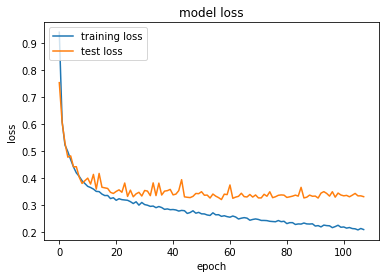

In [17]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training loss', 'test loss'], loc='upper left')
plt.show()

In [18]:
#Open and read Weights file.
Weights=os.listdir("Weights")

#For min_bound until the last epoch compute RMSLE score for X_test
min_bound=len(Weights)-20

#Create numpy array to store epoch and RMSLE
weights_final=np.zeros([len(Weights),2])

#Compute and store poch and RMSLE
for j in range(min_bound,len(Weights)):
    weights_file = 'Weights/'+ Weights[j] #choose checkpoint 
    NN_model.load_weights(weights_file) #load it
    NN_model.compile(loss=RMSLE, optimizer='adam', metrics=[RMSLE])
    y_pred = NN_model.predict(X_test)
    for i, _  in enumerate(y_pred):
        if y_pred[i] < 0:
            y_pred[i] = 0
    weights_final[j][0]=j #Store epoch
    weights_final[j][1]=np.sqrt(mean_squared_log_error(y_test, y_pred)) #Store Rmsle

C:\Users\zisis\AppData\Roaming\Python\Python39\site-packages\tensorflow\python\data\ops\dataset_ops.py:3703: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable.debug_mode()`.
  warnings.warn(
C:\Users\zisis\AppData\Roaming\Python\Python39\site-packages\tensorflow\python\data\ops\dataset_ops.py:3703: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable.debug_mode()`.
  warnings.warn(
C:\Users\zisis\AppData\Roaming\Python\Python39\site-packages\tensorflow\python\data\ops\dataset_ops.py:3703: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager 

C:\Users\zisis\AppData\Roaming\Python\Python39\site-packages\tensorflow\python\data\ops\dataset_ops.py:3703: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable.debug_mode()`.
  warnings.warn(
C:\Users\zisis\AppData\Roaming\Python\Python39\site-packages\tensorflow\python\data\ops\dataset_ops.py:3703: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable.debug_mode()`.
  warnings.warn(
C:\Users\zisis\AppData\Roaming\Python\Python39\site-packages\tensorflow\python\data\ops\dataset_ops.py:3703: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager 

In [19]:
#Delete the row with zeros
weights_final=np.delete(weights_final,range(0,min_bound), axis=0)

#Sort by RMSLE
weights_final=weights_final[weights_final[:,1].argsort()]

In [20]:
#Print results
for j in range(0,len(weights_final)):
    print(str(weights_final[j][0])+' RMSLE:', str(weights_final[j][1]))

91.0 RMSLE: 0.306015833072703
95.0 RMSLE: 0.30673874696059256
90.0 RMSLE: 0.30851921087878337
107.0 RMSLE: 0.30943899832584476
103.0 RMSLE: 0.31052233497643117
105.0 RMSLE: 0.31082354985278193
89.0 RMSLE: 0.3134942099345519
100.0 RMSLE: 0.31413164073563454
97.0 RMSLE: 0.3156135829841253
99.0 RMSLE: 0.3164075961822907
102.0 RMSLE: 0.3165049118095616
94.0 RMSLE: 0.3170205311202556
106.0 RMSLE: 0.31818377648420665
101.0 RMSLE: 0.31983906915191274
98.0 RMSLE: 0.3207523775244646
88.0 RMSLE: 0.32238426274481685
96.0 RMSLE: 0.32320078393710033
104.0 RMSLE: 0.3253977736447699
92.0 RMSLE: 0.3288702391020814
93.0 RMSLE: 0.336105003117066


In [21]:
weights_file = 'Weights/'+ Weights[int(weights_final[0][0])] #Choose the best checkpoint 
NN_model.load_weights(weights_file) #Load it
NN_model.compile(loss=RMSLE, optimizer='adam', metrics=[RMSLE]) #Compile it

Moreover, we use ensembles in order to combine predictions from different models to generate a final prediction. So, we create some methods which facilitate the fuctionality of the ensembles. 
First, the method get_models() returns a list that contains the different models for use.

In [22]:
def get_models():
    
    #generate base learners
    
    rfr = RandomForestRegressor(n_estimators=500)
    rfr2 = RandomForestRegressor(n_estimators = 800)
    rfr3 = RandomForestRegressor(n_estimators = 300)
    etr = ExtraTreesRegressor(n_estimators=800)
    etr2 = ExtraTreesRegressor(n_estimators = 600)
    NN_model = Sequential()

    # The Input Layer :
    NN_model.add(Dense(1024, kernel_initializer='normal',input_dim = X.shape[1], activation='relu'))
    # The Hidden Layers :
    NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))
    NN_model.add(Dense(1024, kernel_initializer='normal',activation='relu'))
    NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))
    # The Output Layer :
    NN_model.add(Dense(1, kernel_initializer='normal',activation='linear'))
    # Compile the network :
    NN_model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_error'])
    NN_model.summary()
 
    models ={
        'rfr':rfr,
        'rfr2':rfr2,
        'rfr3':rfr3,
        'etr':etr,
        'etr2':etr2,
        'NN_model':NN_model
    }
    
    return models

models = get_models()
print('Models are ready...')

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 1024)              22528     
_________________________________________________________________
dense_6 (Dense)              (None, 256)               262400    
_________________________________________________________________
dense_7 (Dense)              (None, 1024)              263168    
_________________________________________________________________
dense_8 (Dense)              (None, 256)               262400    
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 257       
Total params: 810,753
Trainable params: 810,753
Non-trainable params: 0
_________________________________________________________________
Models are ready...


Then, train_predict() is used to fit each model with (X_train,y_train) and make predictions with X_test data. The predictions of every model are inserted at a numpy array (Predictions).

In [23]:
def train_predict(model_list,Xtrain,ytrain,Xtest,ytest):
    #fit models in list on training set and return predictions
    Predictions = np.zeros((Xtest.shape[0],len(model_list)))
    Predictions = pd.DataFrame(Predictions)
    
    print("Fitting models")
    
    cols=list()
    for i,(name,model) in enumerate(models.items()):
        print("%s..." % name, end=" ", flush=False)
        if(name!="NN_model"):
            model.fit(Xtrain, ytrain) 
            p = model.predict(Xtest)[:]
            Predictions.iloc[:,i]=p
            cols.append(name)
            print("done")
        else:
            model.fit(Xtrain, ytrain, epochs=150, batch_size=64, validation_split = 0.2) 
            p = model.predict(Xtest)[:]
            Predictions.iloc[:,i]=p
            cols.append(name)
            print("done")
        
        
        
    Predictions.columns = cols
    print("Done.\n")
    return Predictions

P = train_predict(models,X_train,y_train,X_test,y_test)

Fitting models
rfr... done
rfr2... done
rfr3... done
etr... done
etr2... done
NN_model... Epoch 1/150
  3/122 [..............................] - ETA: 3s - loss: 183.9504 - mean_absolute_error: 183.9504

C:\Users\zisis\AppData\Roaming\Python\Python39\site-packages\tensorflow\python\data\ops\dataset_ops.py:3703: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable.debug_mode()`.
  warnings.warn(


122/122 [==============================] - 4s 30ms/step - loss: 112.1150 - mean_absolute_error: 112.1150 - val_loss: 85.6463 - val_mean_absolute_error: 85.6463
Epoch 2/150
122/122 [==============================] - 4s 29ms/step - loss: 82.9814 - mean_absolute_error: 82.9814 - val_loss: 72.1503 - val_mean_absolute_error: 72.1503
Epoch 3/150
122/122 [==============================] - 3s 27ms/step - loss: 75.1982 - mean_absolute_error: 75.1982 - val_loss: 67.5479 - val_mean_absolute_error: 67.5479
Epoch 4/150
122/122 [==============================] - 3s 28ms/step - loss: 69.5602 - mean_absolute_error: 69.5602 - val_loss: 66.9039 - val_mean_absolute_error: 66.9039
Epoch 5/150
122/122 [==============================] - 3s 28ms/step - loss: 65.3315 - mean_absolute_error: 65.3315 - val_loss: 58.2897 - val_mean_absolute_error: 58.2897
Epoch 6/150
122/122 [==============================] - 4s 32ms/step - loss: 60.3020 - mean_absolute_error: 60.3020 - val_loss: 55.5147 - val_mean_absolute_error

122/122 [==============================] - 4s 29ms/step - loss: 27.9760 - mean_absolute_error: 27.9760 - val_loss: 27.7401 - val_mean_absolute_error: 27.7401
Epoch 50/150
122/122 [==============================] - 4s 32ms/step - loss: 26.4235 - mean_absolute_error: 26.4235 - val_loss: 32.3015 - val_mean_absolute_error: 32.3015
Epoch 51/150
122/122 [==============================] - 4s 35ms/step - loss: 27.0712 - mean_absolute_error: 27.0712 - val_loss: 28.7321 - val_mean_absolute_error: 28.7321
Epoch 52/150
122/122 [==============================] - 4s 33ms/step - loss: 26.1420 - mean_absolute_error: 26.1420 - val_loss: 29.0013 - val_mean_absolute_error: 29.0013
Epoch 53/150
122/122 [==============================] - 4s 33ms/step - loss: 26.3986 - mean_absolute_error: 26.3986 - val_loss: 28.6281 - val_mean_absolute_error: 28.6281
Epoch 54/150
122/122 [==============================] - 4s 33ms/step - loss: 25.9279 - mean_absolute_error: 25.9279 - val_loss: 29.9290 - val_mean_absolute_er

Epoch 97/150
122/122 [==============================] - 4s 33ms/step - loss: 22.7839 - mean_absolute_error: 22.7839 - val_loss: 26.9417 - val_mean_absolute_error: 26.9417
Epoch 98/150
122/122 [==============================] - 4s 33ms/step - loss: 22.5569 - mean_absolute_error: 22.5569 - val_loss: 26.0672 - val_mean_absolute_error: 26.0672
Epoch 99/150
122/122 [==============================] - 4s 33ms/step - loss: 22.6427 - mean_absolute_error: 22.6427 - val_loss: 27.4039 - val_mean_absolute_error: 27.4039
Epoch 100/150
122/122 [==============================] - 4s 33ms/step - loss: 22.6796 - mean_absolute_error: 22.6796 - val_loss: 25.9188 - val_mean_absolute_error: 25.9188
Epoch 101/150
122/122 [==============================] - 4s 33ms/step - loss: 22.2145 - mean_absolute_error: 22.2145 - val_loss: 28.5808 - val_mean_absolute_error: 28.5808
Epoch 102/150
122/122 [==============================] - 4s 33ms/step - loss: 22.0820 - mean_absolute_error: 22.0820 - val_loss: 25.8051 - val_

122/122 [==============================] - 4s 36ms/step - loss: 18.9796 - mean_absolute_error: 18.9796 - val_loss: 25.9691 - val_mean_absolute_error: 25.9691
Epoch 145/150
122/122 [==============================] - 4s 33ms/step - loss: 19.7271 - mean_absolute_error: 19.7271 - val_loss: 25.9846 - val_mean_absolute_error: 25.9846
Epoch 146/150
122/122 [==============================] - 4s 33ms/step - loss: 19.6722 - mean_absolute_error: 19.6722 - val_loss: 26.8017 - val_mean_absolute_error: 26.8017
Epoch 147/150
122/122 [==============================] - 4s 33ms/step - loss: 20.4940 - mean_absolute_error: 20.4940 - val_loss: 25.4049 - val_mean_absolute_error: 25.4049
Epoch 148/150
122/122 [==============================] - 4s 33ms/step - loss: 19.6054 - mean_absolute_error: 19.6054 - val_loss: 27.5794 - val_mean_absolute_error: 27.5794
Epoch 149/150
122/122 [==============================] - 4s 33ms/step - loss: 19.4354 - mean_absolute_error: 19.4354 - val_loss: 25.5372 - val_mean_absolu

C:\Users\zisis\AppData\Roaming\Python\Python39\site-packages\tensorflow\python\data\ops\dataset_ops.py:3703: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable.debug_mode()`.
  warnings.warn(


done
Done.



The score_models() method takes as arguments the Predictions array and y_test data in order to score each model. Finally, we combine the predictions by applying the mean function at every row of the Predictions array, and we calculate the RMSLE score.

In [24]:
def score_models(Predictions,y):
    #score model in prediction df
    print("Scoring models.")
    for model in Predictions.columns:
        for i,_ in enumerate(y):
            if Predictions.loc[i,model]<0:
                Predictions.loc[i,model]=0
        print('RMSLE '+model+' :', np.sqrt(mean_squared_log_error(y, Predictions.loc[:,model])))
    print("Done. \n")
    
score_models(P,y_test)

mean_predict = P.mean(axis=1)
print('RMSLE mean_predictions :', np.sqrt(mean_squared_log_error(y_test, mean_predict)))

Scoring models.
RMSLE rfr : 0.3421042292614833
RMSLE rfr2 : 0.34259405746464444
RMSLE rfr3 : 0.3415238529486971
RMSLE etr : 0.33066305753348557
RMSLE etr2 : 0.33132566865874724
RMSLE NN_model : 0.30055109443061745
Done. 

RMSLE mean_predictions : 0.3200486442846384


To create submission.csv we train the model to the whole training set.

# Kaggle Submission

Now we will use the fitted model to make predictions for the **given** test set. First we load the test set and then follow the same preprocessing steps as for train set.

In [25]:
# Reading test data from the local storage
filename = 'test.csv' 
df_test = pd.read_csv(filename)
print(df_test.shape)
df_test.head(5)

(5214, 12)


,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed
0,1,1,1,20,0,4,1,1,0.26,0.2121,0.52,0.4478
1,4,1,10,15,0,5,1,1,0.52,0.5000,0.42,0.4478
2,1,0,1,10,0,0,0,1,0.22,0.2121,0.51,0.2836
3,3,1,8,18,0,3,1,1,0.74,0.6667,0.51,0.2239
4,1,1,2,8,0,1,1,1,0.24,0.2424,0.60,0.0000


Whatever preprocessing we did to training data, we have to do also to test data.

Rename Column Names

In [26]:
df_test.rename(columns={'weathersit':'weather',
                     'mnth':'month',
                     'hr':'hour',
                     'yr':'year',
                     'hum': 'humidity',
                     'cnt':'count'},inplace=True)
df_test.head()

,season,year,month,hour,holiday,weekday,workingday,weather,temp,atemp,humidity,windspeed
0,1,1,1,20,0,4,1,1,0.26,0.2121,0.52,0.4478
1,4,1,10,15,0,5,1,1,0.52,0.5000,0.42,0.4478
2,1,0,1,10,0,0,0,1,0.22,0.2121,0.51,0.2836
3,3,1,8,18,0,3,1,1,0.74,0.6667,0.51,0.2239
4,1,1,2,8,0,1,1,1,0.24,0.2424,0.60,0.0000


In [27]:
#Convert to object type
df_test['season'] = df_test.season.astype('object')
#df_test['year'] = df_test.year.astype('object')
#df_test['month'] = df_test.month.astype('object')
#df_test['hour'] = df_test.hour.astype('object')#category
df_test['holiday'] = df_test.holiday.astype('object')
df_test['weekday'] = df_test.weekday.astype('object')
df_test['workingday'] = df_test.workingday.astype('object')
#df_test['weather'] = df_test.weather.astype('object')

df_test.dtypes

season         object
year            int64
month           int64
hour            int64
holiday        object
weekday        object
workingday     object
weather         int64
temp          float64
atemp         float64
humidity      float64
windspeed     float64
dtype: object

In [28]:
df_test = df_test.drop(['windspeed'], axis=1)
df_test.head()

,season,year,month,hour,holiday,weekday,workingday,weather,temp,atemp,humidity
0,1,1,1,20,0,4,1,1,0.26,0.2121,0.52
1,4,1,10,15,0,5,1,1,0.52,0.5000,0.42
2,1,0,1,10,0,0,0,1,0.22,0.2121,0.51
3,3,1,8,18,0,3,1,1,0.74,0.6667,0.51
4,1,1,2,8,0,1,1,1,0.24,0.2424,0.60


In [29]:
#Test data
df_test = df_test[['season','year','month','hour','holiday','weekday','workingday','weather','atemp','humidity']]

#One-hot encoding technique for better performance
df_test = pd.get_dummies(df_test)

In [30]:
#Predict
y_pred = NN_model.predict(df_test)
for i, y  in enumerate(y_pred):
    if y_pred[i] < 0:
        y_pred[i] = 0

C:\Users\zisis\AppData\Roaming\Python\Python39\site-packages\tensorflow\python\data\ops\dataset_ops.py:3703: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable.debug_mode()`.
  warnings.warn(
C:\Users\zisis\AppData\Roaming\Python\Python39\site-packages\tensorflow\python\data\ops\dataset_ops.py:3703: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable.debug_mode()`.
  warnings.warn(


Prepare a pandas dataframe according to submission format and save it to `submission.csv`:

In [31]:
#We create submission.csv and write it to disk
submission = pd.DataFrame()
submission['Id'] = range(y_pred.shape[0])
submission['Predicted'] = y_pred
submission.to_csv("submission.csv", index=False)

These submission gave us a 0.28 RMSLE score at Kaggle's leaderboard. We saw that some submissions, with the same rmsle score, got different values for the same test example, so we decided to get the mean of these submissions.

In [33]:
# filename1 = 'submission1.csv' 
# sub1 = pd.read_csv(filename1)
# print(sub1.shape)
# sub1.head(5)

In [34]:
# filename2 = 'submission2.csv' 
# sub2 = pd.read_csv(filename2)
# print(sub2.shape)
# sub2.head(5)

In [ ]:
#Create the mean
mean=np.zeros((sub1.shape[0],1))
for i in range(mean.shape[0]):
    mean[i][0]=(sub1['Predicted'][i]+sub2['Predicted'][i])/2
    
#Create the Predicted Column
dataset = pd.DataFrame({'Predicted': mean[:, 0]})

In [ ]:
#Create the new sumbission and store it to disk
submission_mean = pd.DataFrame()
submission_mean['Id'] = range(mean.shape[0])
submission_mean['Predicted']=dataset['Predicted'][:] 
submission_mean.shape
submission_mean.to_csv("submission_mean.csv", index=False)

Our final RMSLE Score: 0.26379